In [77]:
from google.colab import drive
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:

# Dataset directories
train_dir = '/content/drive/My Drive/dataset'
test_dir = '/content/drive/My Drive/Test data'

In [ ]:
def load_and_process_images(data_path, img_size=64):
    image_data = []
    image_labels = []
    categories_list = ['Knight', 'Bishop', 'Queen', 'Rook', 'Pawn']

    for label, category in enumerate(categories_list):
        category_path = os.path.join(data_path, category)
        if not os.path.exists(category_path):
            print(f"Warning: {category_path} does not exist. Skipping.")
            continue
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: {img_path} could not be loaded. Skipping.")
                continue
            img_resized = cv2.resize(img, (img_size, img_size))
            image_data.append(img_resized.flatten() / 255.0)
            image_labels.append(label)
    return np.array(image_data), np.array(image_labels, dtype=np.int32)


In [ ]:

# Load training and testing data
X_train, y_train = load_and_process_images(train_dir)
X_test, y_test = load_and_process_images(test_dir)



In [ ]:

# Encode labels as one-hot vectors
def encode_labels(labels, num_classes=5):
    encoded = np.zeros((labels.size, num_classes))
    encoded[np.arange(labels.size), labels] = 1
    return encoded

y_train = encode_labels(y_train, num_classes=5)
y_test = encode_labels(y_test, num_classes=5)

# Neural network parameters
input_dim = 64 * 64
hidden_units = 512
output_classes = 5
lr = 0.01

# Initialize weights and biases
weight1 = np.random.randn(hidden_units, input_dim) * 0.01
bias1 = np.zeros((hidden_units, 1))
weight2 = np.random.randn(output_classes, hidden_units) * 0.01
bias2 = np.zeros((output_classes, 1))


In [ ]:


def relu_activation(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax_activation(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=0, keepdims=True)


def forward_pass(X):
    global weight1, bias1, weight2, bias2
    Z1 = np.dot(weight1, X.T) + bias1
    A1 = relu_activation(Z1)
    Z2 = np.dot(weight2, A1) + bias2
    A2 = softmax_activation(Z2)
    cache = (Z1, A1, Z2, A2)
    return A2, cache


def calculate_loss(Y, A2):
    m = Y.shape[0]
    log_probs = -np.log(A2.T[range(m), np.argmax(Y, axis=1)])
    loss = np.sum(log_probs) / m
    return loss


def backward_pass(X, Y, cache):
    global weight1, bias1, weight2, bias2
    Z1, A1, Z2, A2 = cache
    m = X.shape[0]
    dZ2 = A2.T - Y
    dweight2 = np.dot(dZ2.T, A1.T) / m
    dbias2 = np.sum(dZ2.T, axis=1, keepdims=True) / m
    dZ1 = np.dot(weight2.T, dZ2.T) * relu_derivative(Z1)
    dweight1 = np.dot(dZ1, X) / m
    dbias1 = np.sum(dZ1, axis=1, keepdims=True) / m
    return dweight1, dbias1, dweight2, dbias2


def apply_gradients(dweight1, dbias1, dweight2, dbias2):
    global weight1, bias1, weight2, bias2
    weight1 -= lr * dweight1
    bias1 -= lr * dbias1
    weight2 -= lr * dweight2
    bias2 -= lr * dbias2


In [ ]:
def visualize_network():
    print("Neural Network Architecture:")
    print(f"Input Layer: {input_dim} nodes")
    print(f"Hidden Layer: {hidden_units} nodes")
    print(f"Output Layer: {output_classes} nodes")

visualize_network()


Neural Network Architecture:
Input Layer: 4096 nodes
Hidden Layer: 512 nodes
Output Layer: 5 nodes


In [ ]:

# Training loop
epochs = 3000
for epoch in range(epochs):
    A2, cache = forward_pass(X_train)
    loss = calculate_loss(y_train, A2)
    dweight1, dbias1, dweight2, dbias2 = backward_pass(X_train, y_train, cache)
    apply_gradients(dweight1, dbias1, dweight2, dbias2)

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss = {loss}")



Epoch 0: Loss = 1.6221452897056148
Epoch 200: Loss = 1.3267989264106927
Epoch 400: Loss = 1.0886068540742926
Epoch 600: Loss = 0.8724615033999191
Epoch 800: Loss = 0.7359640606615824
Epoch 1000: Loss = 0.6202522784474043
Epoch 1200: Loss = 0.5375388665123517
Epoch 1400: Loss = 0.43699949158479867
Epoch 1600: Loss = 0.3581686491866331
Epoch 1800: Loss = 0.29940938593344135
Epoch 2000: Loss = 0.2870580830483523
Epoch 2200: Loss = 0.19670961170134935
Epoch 2400: Loss = 0.15685804404427345
Epoch 2600: Loss = 0.1284710527764566
Epoch 2800: Loss = 0.10897287893347793


In [ ]:

# Prediction
def predict(X):
    A2, _ = forward_pass(X)
    return np.argmax(A2, axis=0)

y_pred = predict(X_test)
y_true = np.argmax(y_test, axis=1)

accuracy = np.mean(y_pred == y_true) * 100
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 52.00%


In [79]:

# Single image preprocessing
def preprocess_single_image(img_path, img_size=64):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Could not load image at {img_path}. Check the path and file existence.")
        return None
    img_resized = cv2.resize(img, (img_size, img_size))
    img_flattened = img_resized.flatten() / 255.0
    return img_flattened
import matplotlib.pyplot as plt  # Add this at the top of your script

# Single image classification
def classify_image(img_path):
    X = preprocess_single_image(img_path)
    if X is None:
        return "Unknown"

    # Display the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        plt.imshow(img, cmap='gray')
        plt.title("Uploaded Image")
        plt.axis('off')
        plt.show()
    else:
        print("Unable to display the image.")

    # Perform classification
    X = X.reshape(1, -1)
    A2, _ = forward_pass(X)
    predicted_label = np.argmax(A2, axis=0)[0]
    categories_list = ['Knight', 'Bishop', 'Queen', 'Rook', 'Pawn']
    return categories_list[predicted_label]



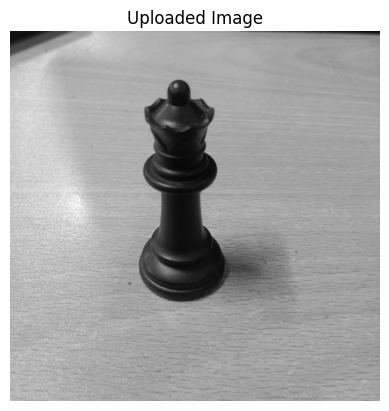

The predicted class for the image is: Queen


In [90]:

# Test single image classification
new_image_path = '/content/IMG_20241210_125600.jpg'
predicted_class = classify_image(new_image_path)
print(f"The predicted class for the image is: {predicted_class}")